# Introduction To Data Science HW6 Data Cleaning for Netflix Prize 

## This HW, we need to do the data cleaning for Netflix Prize Data
## In the below is the dataset description
TRAINING DATASET FILE DESCRIPTION
================================================================================
In this part, we have 4 files "combined_data_1.txt", "combined_data_2.txt", "combined_data_3.txt", "combined_data_4.txt"

THe format is in the below: 

CustomerID,Rating,Date

- MovieIDs range from 1 to 17770 sequentially.
- CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
- Ratings are on a five star (integral) scale from 1 to 5.
- Dates have the format YYYY-MM-DD.

MOVIES FILE DESCRIPTION
================================================================================

Movie information in "movie_titles.csv" is in the following format:

MovieID,YearOfRelease,Title

- MovieID do not correspond to actual Netflix movie ids or IMDB movie ids.
- YearOfRelease can range from 1890 to 2005 and may correspond to the release of
  corresponding DVD, not necessarily its theaterical release.
- Title is the Netflix movie title and may not correspond to 
  titles used on other sites.  Titles are in English.


QUALIFYING AND PREDICTION DATASET FILE DESCRIPTION
================================================================================

The qualifying dataset for the Netflix Prize is contained in the text file
"qualifying.txt".  It consists of lines indicating a movie id, followed by a
colon, and then customer ids and rating dates, one per line for that movie id.
The movie and customer ids are contained in the training set.  Of course the
ratings are withheld. There are no empty lines in the file.

MovieID1:
CustomerID11,Date11
CustomerID12,Date12
...
MovieID2:
CustomerID21,Date21
CustomerID22,Date22

For the Netflix Prize, your program must predict the all ratings the customers
gave the movies in the qualifying dataset based on the information in the
training dataset.

The format of your submitted prediction file follows the movie and customer id,
date order of the qualifying dataset.  However, your predicted rating takes the
place of the corresponding customer id (and date), one per line.

For example, if the qualifying dataset looked like:

111:
3245,2005-12-19
5666,2005-12-23
6789,2005-03-14


# Fist Deal with training set data cleaning

In [140]:
# To show graphs in jupyter notebook using %matplotlib inline 
%matplotlib inline 

# Import shutil, numby, pandas, seaborn, matplotlib.pyplot, dask.dataframe, dask.array libraries
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da

In [36]:
# To show multiple execution in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [37]:
# Combine all combined data together into one 2G csv file
with open("/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data.csv",'w') as wfd:
    for f in ["/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data_1.txt", "/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data_2.txt", "/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data_3.txt", "/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data_4.txt"]:
        with open(f,'r') as fd:
            shutil.copyfileobj(fd, wfd, 1024*1024*10)
            #10MB per writing chunk to avoid reading big file into memory.

In [38]:
# Read the combined csv file and give the column names ['CustomerID', 'Rating', 'Date']
train = dd.read_csv("/Users/ChienMingHuang/Desktop/netflix-prize-data/combined_data.csv", header = None, names = ['CustomerID', 'Rating', 'Date'])

# Read the first 5 rows of train
train.head()
# we can see that the file that has some messy becasue the dataset put the customerid and movieid into the same column

,CustomerID,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [156]:
p = train.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = train.isnull().sum()[1]

# get customer count
cust_count = train['CustomerID'].nunique() - movie_count

# get rating count
rating_count = train['CustomerID'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

NotImplementedError: 

In [182]:
movie_count = sum(da.isnull(dd.to_records(train)))[1]
#movie_count = sum(dd.Series.to_frame(dd.Series.isnull(train.Rating)))
movie_count
type(movie_count)


ValueError: ('Arrays chunk sizes are unknown: %s', (nan,))

In [172]:
?dd.to_records

In [154]:
# In this part, we need to reconstructure the training set
# First we need to find out which rows are movieid rows and pick them out 
# Use dd.Series.isnull() to find train.Rating is NaN then use dd.Series.to_frame convert series to frame
train_nan= dd.Series.to_frame(dd.Series.isnull(train.Rating))

# Select those true value in Rating which means choosing all the movieid rows
train_nan = train_nan[train_nan.Rating == True]

# Reset the index for train_nan, then keep the origin index representing movieid rows as a column
train_nan = train_nan.reset_index()

# Read the first 5 rows of train_nan which representing the index row of movieid
train_nan.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [153]:
# Later we create a numpy list for movieid later to put in
# set movie_np as a list
movie_np = []

# set movie_id starts at 1
movie_id = 1

# build up the movie_np list and using movie_id doing loop 
for i,j in zip(train_nan['index'][1:],train_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = movie_np.append(temp)
    movie_id += 1

print(movie_np)


NotImplementedError: 

In [ ]:
# Account for last record and corresponding length
last_record = np.full((1,len(train) - train_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

In [ ]:
# remove those Movie ID rows with NaN Rating field
train = train[pd.notnull(train.Rating)]

# Change the MovieID data type as integer
train.MovieID = movie_np.astype(int)

# Change the CustomerID data type as integer
train.CustomerID = train.CustomerID.astype(int)

# Read the first 5 rows of train with correct column that shows customerid, rating, date, movieid
train.head()

print('-Dataset examples-')
print(df.iloc[::5000000, :])

# Second Deal with movie_titles.csv data cleaning

In [52]:
# To deal with extra commas in movie title, we need to change the delimiter to |
# Import csv library
import csv

# set the origin file as f and fixed file as g, and do the encoding="ISO-8859-1" to prevent unicode encoding problem
# Use csv.writer() and change the delimiter = |
# The problem is that movie_title has extra comma inside, so we only do the split with first 2 commas
with open("/Users/ChienMingHuang/Desktop/netflix-prize-data/movie_titles.csv", 'r', encoding="ISO-8859-1") as f, open("/Users/ChienMingHuang/Desktop/netflix-prize-data/movie_titles_revised.csv", 'w', encoding="ISO-8859-1") as g:
    writer = csv.writer(g, delimiter='|')
    for line in f:
        row = line.split(',', 2)
        writer.writerow(row)

In [133]:
# read movie_title revised csv and check the file 
movie= pd.read_csv("/Users/ChienMingHuang/Desktop/netflix-prize-data/movie_titles_revised.csv", sep ='|', header = None, encoding ="ISO-8859-1")

# Read the first 5 rows of movie
movie.head()
# We found out we have to give the header name and fix the data type, that year has no .0 and the movie title has remove \n

,0,1,2
0,1,2003.0,Dinosaur Planet\n
1,2,2004.0,Isle of Man TT 2004 Review\n
2,3,1997.0,Character\n
3,4,1994.0,Paula Abdul's Get Up & Dance\n
4,5,2004.0,The Rise and Fall of ECW\n


In [134]:
# Add movie header as the netflix description
movie.columns = ["MovieID", "YearOfRelease", "Title"]

# Read the first 5 rows of movie and check the header
movie.head()

,MovieID,YearOfRelease,Title
0,1,2003.0,Dinosaur Planet\n
1,2,2004.0,Isle of Man TT 2004 Review\n
2,3,1997.0,Character\n
3,4,1994.0,Paula Abdul's Get Up & Dance\n
4,5,2004.0,The Rise and Fall of ECW\n


In [135]:
# Change YearOfRelase datatype using astype() to object
movie.YearOfRelease = movie.YearOfRelease.astype(object)

# Read the first 5 rows of movie and check the YearOfRelase
movie.head()

,MovieID,YearOfRelease,Title
0,1,2003,Dinosaur Planet\n
1,2,2004,Isle of Man TT 2004 Review\n
2,3,1997,Character\n
3,4,1994,Paula Abdul's Get Up & Dance\n
4,5,2004,The Rise and Fall of ECW\n


In [136]:
# Remove the regular expression in Title using .replace() to remove \n, and set regex= True
movie.Title = movie.Title.replace('\n','', regex=True)

# Read the first 5 rows of movie and check the Title
movie.head()

,MovieID,YearOfRelease,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [137]:
# Check missing values in each column
movie.isnull().sum()
# We find out there are 7 missing values in the YearOfRelease, we can later set them as NaN

MovieID          0
YearOfRelease    7
Title            0
dtype: int64

In [138]:
# Set the missing value in YearOfRelease as unknown
movie = movie.fillna('unknown')

# Check missing values in each column
movie.isnull().sum()

MovieID          0
YearOfRelease    0
Title            0
dtype: int64

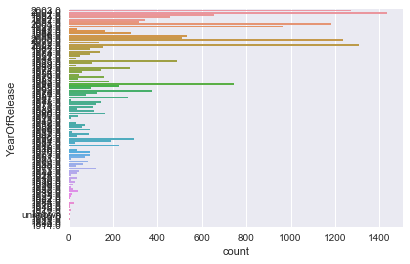

In [120]:
movieyear = sns.countplot(y="YearOfRelease", data=movie, linewidth=5)

# Reference:
1. https://www.kaggle.com/netflix-inc/netflix-prize-data/data
2. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
3. https://www.kaggle.com/laowingkin/movie-recommendation-with-netflix/notebook
